<h1><center><font size="25">Functional testing skforecast</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>March, 2021</i></center>

This notebook performs functional testing for the library skforecast.

For unit testing see folder *tests*.

In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## ForecasterAutoreg

### No exogenous predictor

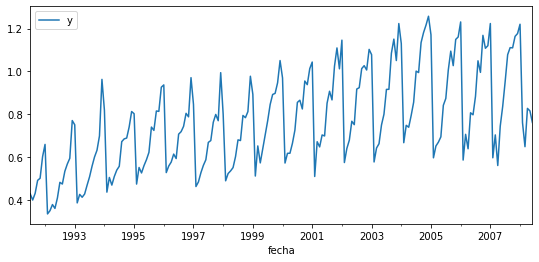

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.011051937043503667


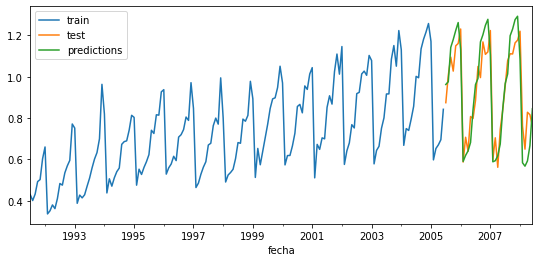

In [5]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Test error (mse): 0.011051937043503738

In [6]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:08:44,018 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:12<00:00,  4.20s/it] 
2021-06-15 11:08:56,622 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.026380
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.026910
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028063
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028660
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.029417
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.032773
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.033446
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.033541
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.035928
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036204


**Expected result (non exact reproducibility):**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.026520  

In [7]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.58859846 0.10828282 0.06074964 0.02718395 0.02711216 0.01383895
 0.03491546 0.01924292 0.02781647 0.09225916]


**Expected result (non exact reproducibility)**

[0.58857871 0.10819445 0.06032462 0.02772937 0.02760762 0.01349508
 0.03496535 0.01883128 0.02761474 0.09265878]

In [8]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:08:56,720 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it] 
2021-06-15 11:09:02,450 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.050038
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.054813
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.056744
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.057524
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.057557
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.058430
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.058698
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.060748
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.061532
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.062290


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.057822

In [9]:
# Autorregresive lineal model statsmodels
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
lags = 15

modelo_ar = AutoReg(datos_train, lags=lags)
res = modelo_ar.fit()
predictions_statsmodels = res.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Autorregresive lineal model Forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
forecaster.fit(y=datos_train)
predictions_forecaster = forecaster.predict(steps=36)

# Predictions from both models must be the equal
# ==============================================================================
print(np.allclose(predictions_statsmodels.values, predictions_forecaster))

# Coeficients from both models must be the equal
# ==============================================================================
print(np.allclose(res.params.values[1:], forecaster.get_coef()))

True
True


/home/ubuntu/miniconda3/envs/cienciadedatos/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


**Expected result:**

True

True

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02150972]


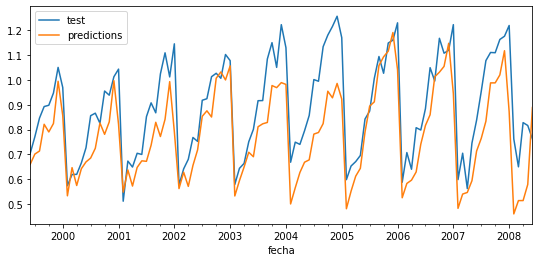

In [10]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result:**

Number of observations used for training: 95

Number of folds: 4

Last fold only includes 1 observations.

[0.02150972]

In [11]:
print(len(predictions_backtest), predictions_backtest)

109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64


**Expected result:**
    
109 fecha
1999-06-01    0.659751
1999-07-01    0.700833
1999-08-01    0.713227
1999-09-01    0.821183
1999-10-01    0.790163
                ...   
2008-02-01    0.459349
2008-03-01    0.513128
2008-04-01    0.513193
2008-05-01    0.578220
2008-06-01    0.888897
Freq: MS, Length: 109, dtype: float64

In [12]:
# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

**Expected result:**
    
True

In [13]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.011051937043503667


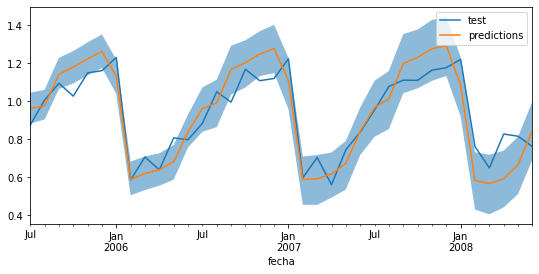

In [14]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.011051937043503738

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.02150972]


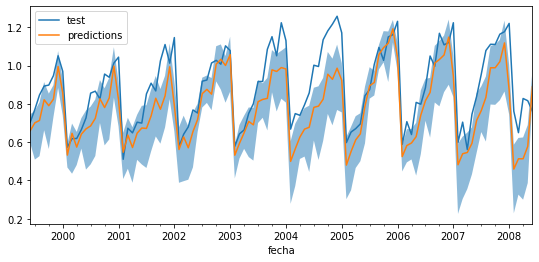

In [15]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [1, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.02150972]

### 1 exogenous predictor
<br>

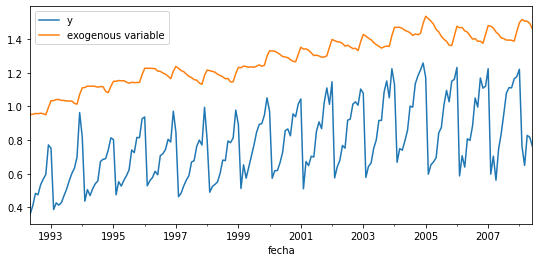

In [16]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235603


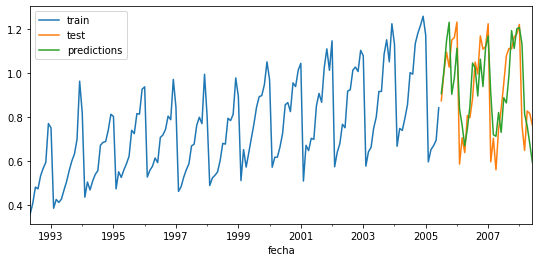

In [17]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.020306077140235405

In [18]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:09:07,069 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:11<00:00,  3.79s/it] 
2021-06-15 11:09:18,433 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028633
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028651
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.029921
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.030834
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.035651
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.037125
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.037546
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040670
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.041554
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044382


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 10, 'n_estimators': 50}	0.028383

In [19]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:09:18,523 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it] 
2021-06-15 11:09:23,977 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.053564
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.058988
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.060391
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062735
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.063141
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.065196
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.065365
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.065736
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.071548
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.072955


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.054245

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


True

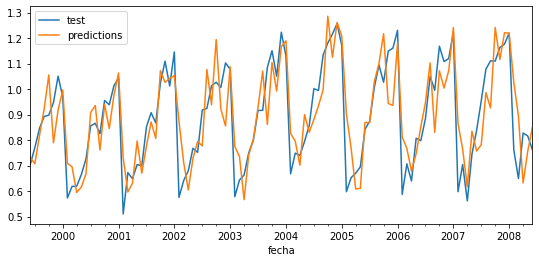

In [20]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
lags  = 8
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

**Expected result**


Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01325921]

True


In [21]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235603


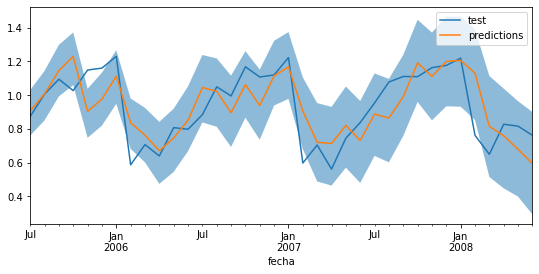

In [22]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.020306077140235405

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


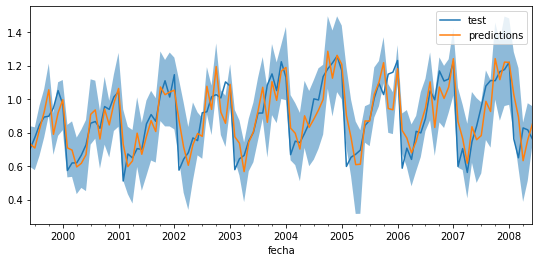

In [23]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

### n exogenous predictors
<br>

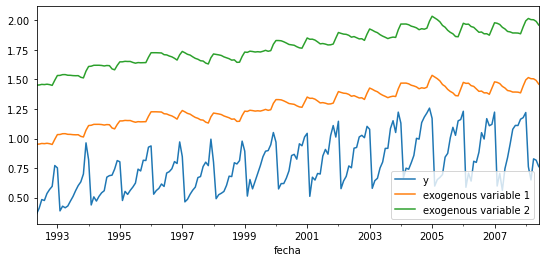

In [24]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.019988962091906936


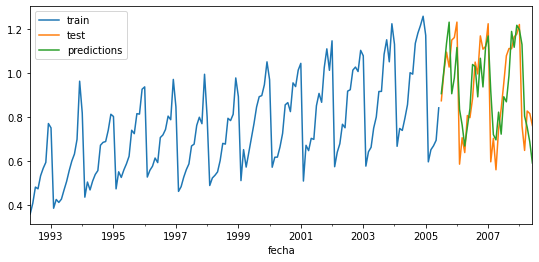

In [25]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.02030607714023512

In [26]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:09:27,720 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:11<00:00,  3.68s/it] 
2021-06-15 11:09:38,776 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.025992
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.027557
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.028406
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.029665
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.036176
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.038405
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.038981
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040189
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.042180
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.042923


**Expected result (non exact reproducibility)**

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]	{'max_depth': 5, 'n_estimators': 50}	0.025775

In [27]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:09:38,858 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it] 
2021-06-15 11:09:44,322 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.052973
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.058093
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.058554
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.059030
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.061910
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.062506
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.063192
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.065945
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.066197
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.066517


**Expected result (non exact reproducibility)**

[1, 2, 3, 20]	{'max_depth': 10, 'n_estimators': 50}	0.053074

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


True

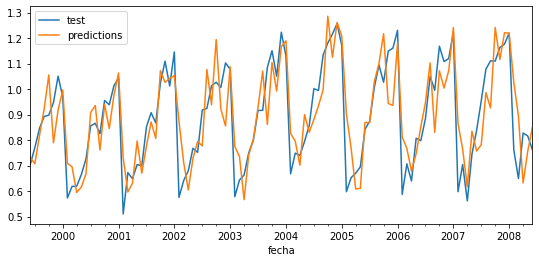

In [28]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01325921]

In [29]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.019988962091906936


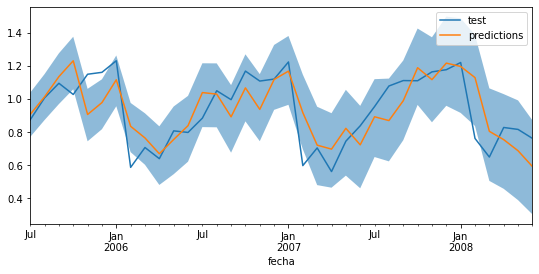

In [30]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected value**

Test error (mse): 0.02030607714023512

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01325921]


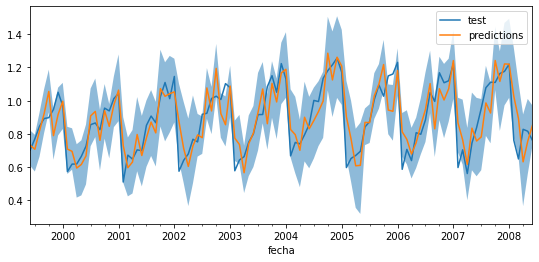

In [31]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected value**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01325921]

## ForecasterCustom

### No exogenous predictor

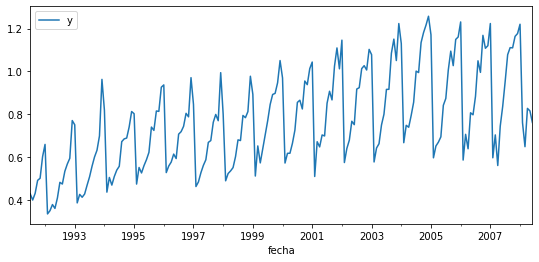

In [32]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [33]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [34]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterCustom=======================
Regressor: LinearRegression()
Predictors created with: create_predictors
Window size: 20
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.02433407566527143


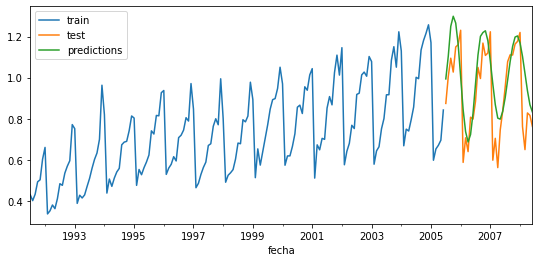

In [35]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.024334075665271356

In [36]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:09:49,016 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it] 
2021-06-15 11:09:56,159 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021719
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022160
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.028122
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.032678


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021727

In [37]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:09:57,039 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:05<00:00,  5.48s/it] 
2021-06-15 11:10:02,518 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.058251
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.058979
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.061320
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.063326


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.058251

In [38]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.57288524 0.10786513 0.04122763 0.01995047 0.02905527 0.00950056
 0.04106364 0.01010964 0.0155692  0.11264308 0.04013015]


**Expected result (non exact reproducibility)**

[0.57297604 0.10797729 0.04122921 0.01996422 0.02964171 0.00950612
 0.04090579 0.0101996  0.01486522 0.11273685 0.03999795]

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06468538]


True

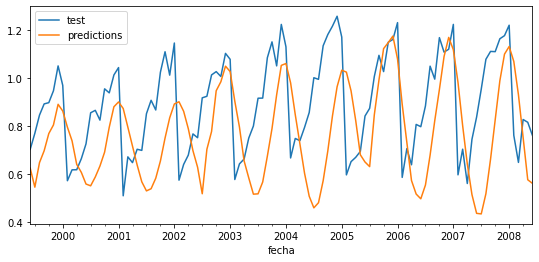

In [39]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 95

Number of folds: 4

Last fold only includes 1 observations.

[0.06468538]

In [40]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

Test error (mse): 0.02433407566527143


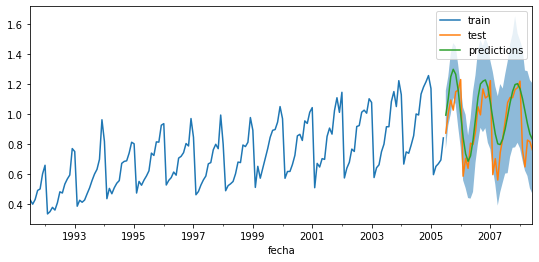

In [41]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 100
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Test error (mse): 0.024334075665271356

Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06468538]


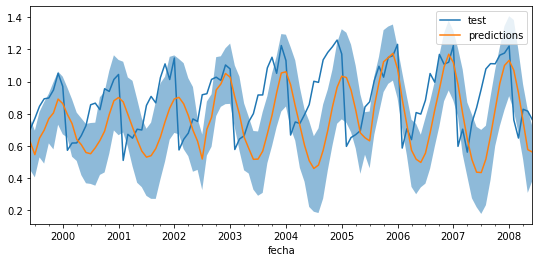

In [42]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result:**
    
Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.06468538]

### 1 exogenous predictor
<br>

In [43]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
np.random.seed(123)
datos_exog = datos.rolling(window=10, closed='right').mean()
datos_exog = datos_exog[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

In [44]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 8 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 8):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train 

Test error (mse): 0.01953290820775546


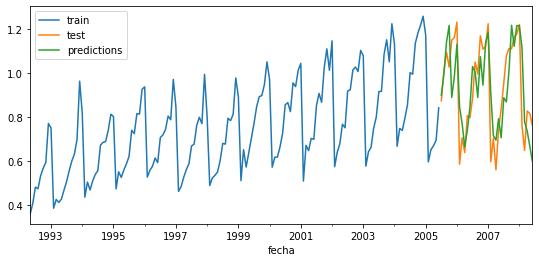

In [45]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.01953290820775534

In [46]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:11:29,025 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:16<00:00, 16.38s/it] 
2021-06-15 11:11:45,411 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.021597
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.022513
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.022614
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.023231


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 10, 'n_estimators': 50}	0.021677


In [47]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:11:46,124 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it] 
2021-06-15 11:11:50,504 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.075071
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.075519
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.077128
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.078833


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.074586

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01351212]


True

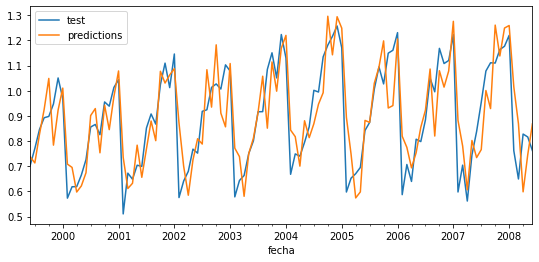

In [48]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01351212]

True

In [49]:
# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.01953290820775546


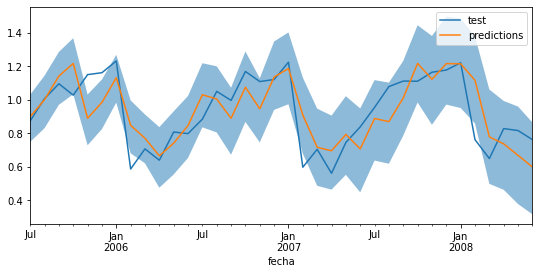

In [50]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected result**

Test error (mse): 0.01953290820775534

Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.01351212]


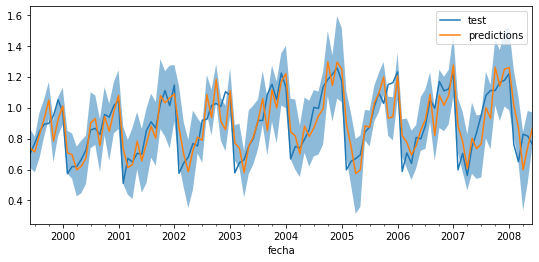

In [51]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
forecaster = ForecasterCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True,
                            verbose             = True
                       )

print(metric)

# Add datetime index
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

**Expected values**

Number of observations used for training: 85
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.01351212]

### n exogenous predictors
<br>

In [52]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

In [53]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 8 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 8):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train 

Test error (mse): 0.019532908207755426


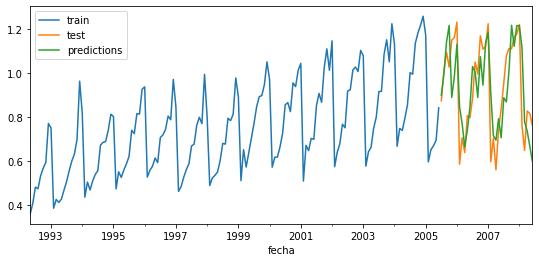

In [54]:
# Create and fit forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 0.019513797137144007

In [55]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:14:12,840 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:16<00:00, 16.40s/it] 
2021-06-15 11:14:29,248 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.023015
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.023074
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.023418
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.023772


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.022885

In [56]:
# Grid search hiperparameters and lags
# ==============================================================================
regressor = RandomForestRegressor(random_state=123)
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:14:30,020 root       INFO  Number of models to fit: 4
loop lags_grid: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it] 
2021-06-15 11:14:34,413 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 100}



,lags,params,metric
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.073052
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.073261
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.074579
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.078530


**Expected result (non exact reproducibility)**

custom predictors	{'max_depth': 5, 'n_estimators': 100}	0.072913

[0.01351212]


True

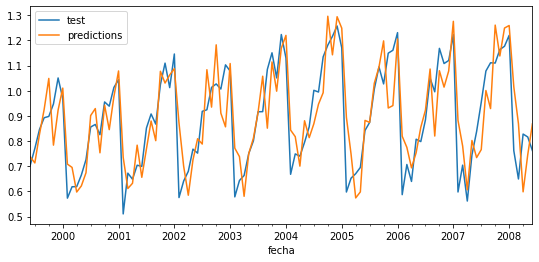

In [57]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test,]
datos_exog_test  = datos_exog[-n_test:,]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterCustom(
                    regressor      = regressor,
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error'
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();


# Check backtesting predictions
forecaster.fit(y=datos_train, exog=datos_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=datos_exog_test[:steps,])
predictions_2 = forecaster.predict(steps=steps, last_window=datos_test[:steps], exog=datos_exog_test[steps:steps*2,])
predictions_3 = forecaster.predict(steps=steps, last_window=datos_test[steps:steps*2], exog=datos_exog_test[steps*2:steps*3,])
predictions_4 = forecaster.predict(steps=1, last_window=datos_test[steps*2:steps*3], exog=datos_exog_test[steps*3:steps*4,])
np.allclose(predictions_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

**Expected result**

Number of observations used for training: 85

Number of folds: 4

Last fold only includes 1 observations.

[0.01351212]

True

## ForecasterAutoregMultiOutput

### No exogenous predictor

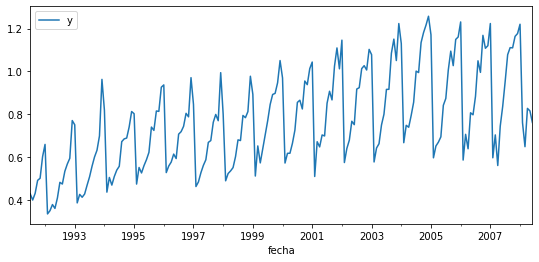

In [58]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [59]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
                )

forecaster.fit(y=datos_train)
forecaster

forecaster

============================ForecasterAutoregMultiOutput============================
Regressor: MultiOutputRegressor(estimator=LinearRegression())
Steps: 36
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__n_jobs': None, 'estimator__normalize': False, 'estimator__positive': False, 'estimator': LinearRegression(), 'n_jobs': None}

Test error (mse): 0.009127719994536935


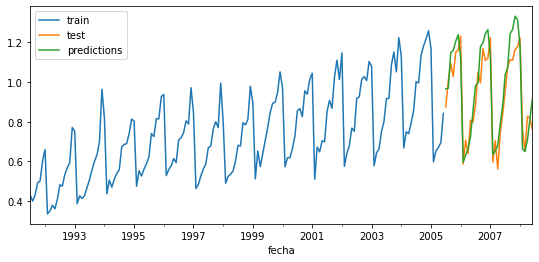

In [60]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Test error (mse): 0.009127719994536924

In [61]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:14:37,829 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [01:08<00:00, 22.87s/it] 
2021-06-15 11:15:46,431 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'estimator__max_depth': 10, 'estimator__n_estimators': 100}



,lags,params,metric
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.013704
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.013845
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.013908
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.014147
8,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.042444
10,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.042569
9,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.043113
11,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.043158
1,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.067097
0,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.067754


**Expected result (non exact reproducibility)**

3	{'estimator__max_depth': 5, 'estimator__n_esti...	0.067066

In [62]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 3
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

2021-06-15 11:15:50,928 root       INFO  Number of models to fit: 12
loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-06-15 11:15:52,652 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]2021-06-15 11:15:56,263 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  50%|█████     | 2/4 [00:05<00:05,  2.51s/it]2021-06-15 11:15:58,457 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:  75%|███████▌  | 3/4 [00:07<00:02,  2.35s/it]2021-06-15 11:16:02,110 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 12 observations are excluded.

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-06-15 11:16:04,335 root       WA

,lags,params,metric
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.019032
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.019130
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.019508
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.019702
8,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.055571
9,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.055999
10,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.056057
11,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.056131
1,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.077963
3,"[1, 2, 3]","{'estimator__max_depth': 10, 'estimator__n_est...",0.078089


**Expected result (non exact reproducibility)**

3	{'estimator__max_depth': 5, 'estimator__n_esti...	0.073741

2021-06-15 11:16:30,222 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 95
Number of observations used for testing: 109
    Number of folds: 3
    Number of steps per fold: 36
[0.0328557]


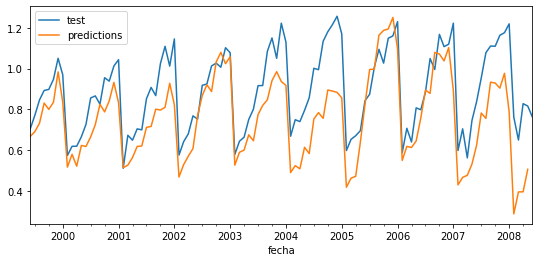

In [63]:
# Backtest 
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 15
             )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest,
                                 index=datos_test[:len(predictions_backtest)].index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**

Number of observations used for training: 95
    
Number of folds: 4
    
Last fold only includes 1 observations.

[0.0328557]

### 1 exogenous predictor
<br>

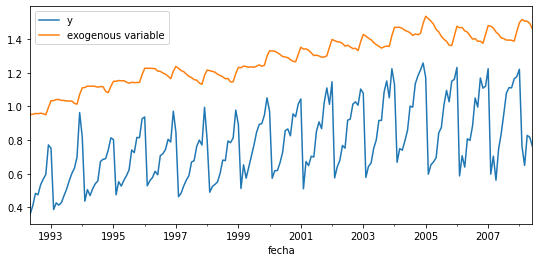

In [64]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 8.664306816746657e-06


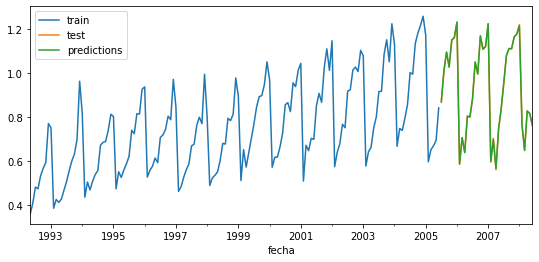

In [65]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=datos_test.index)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

**Expected result**

Test error (mse): 8.664306816747236e-06

In [66]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 8
                )


# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:16:31,118 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [01:25<00:00, 28.45s/it] 
2021-06-15 11:17:56,464 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [1 2 3] 
params: {'estimator__max_depth': 10, 'estimator__n_estimators': 100}



,lags,params,metric
3,"[1, 2, 3]","{'estimator__max_depth': 10, 'estimator__n_est...",0.030164
1,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.030371
2,"[1, 2, 3]","{'estimator__max_depth': 10, 'estimator__n_est...",0.031135
0,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.031195
9,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.032630
8,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.032836
11,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.032838
10,"[1, 2, 3, 20]","{'estimator__max_depth': 10, 'estimator__n_est...",0.033214
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.034331
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.034513


**Expected result (non exact reproducibility)**

3	{'estimator__max_depth': 10, 'estimator__n_est...	0.035194

In [67]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 8
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train,
                        exog        = datos_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = forecaster.steps,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

2021-06-15 11:18:03,462 root       INFO  Number of models to fit: 12
loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-06-15 11:18:05,536 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  25%|██▌       | 1/4 [00:02<00:06,  2.30s/it]2021-06-15 11:18:09,873 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  50%|█████     | 2/4 [00:06<00:05,  2.98s/it]2021-06-15 11:18:12,442 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:  75%|███████▌  | 3/4 [00:09<00:02,  2.79s/it]2021-06-15 11:18:16,868 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 7 observations are excluded.

loop param_grid:   0%|          | 0/4 [00:00<?, ?it/s]2021-06-15 11:18:19,337 root       WARNIN

,lags,params,metric
3,"[1, 2, 3]","{'estimator__max_depth': 10, 'estimator__n_est...",0.049087
1,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.049577
2,"[1, 2, 3]","{'estimator__max_depth': 10, 'estimator__n_est...",0.050643
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.051091
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.051326
0,"[1, 2, 3]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.051417
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.051792
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'estimator__max_depth': 10, 'estimator__n_est...",0.052334
8,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.065877
9,"[1, 2, 3, 20]","{'estimator__max_depth': 5, 'estimator__n_esti...",0.065997


**Expected result (non exact reproducibility)**

3	{'estimator__max_depth': 10, 'estimator__n_est...	0.055089

2021-06-15 11:18:50,489 root       WARNING Backtesting `ForecasterAutoregMultiOutput` only allow completed folds. Last 1 observations are excluded.


Number of observations used for training: 85
Number of observations used for testing: 109
    Number of folds: 3
    Number of steps per fold: 36
[0.05396837]


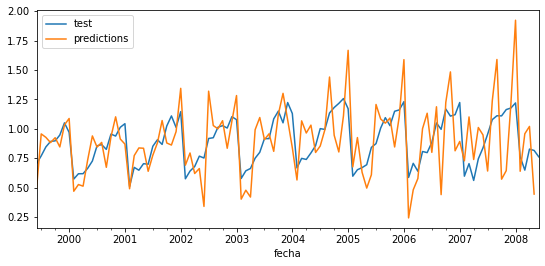

In [68]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = 36,
                    lags      = 8
                )

metric, predictions_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos,
    exog       = datos_exog,
    initial_train_size = len(datos_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metric)

# Add datetime index to predictions
predictions_backtest = pd.Series(data=predictions_backtest, index=datos_test[:len(predictions_backtest)].index)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

**Expected result**


Number of observations used for training: 85

Number of folds: 4

Number of steps per fold: 36

[0.06737841]


## Session information

In [69]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.4.1
numpy       1.20.2
pandas      1.1.3
sinfo       0.3.1
skforecast  0.1.9
sklearn     0.24.1
statsmodels 0.12.2
-----
IPython             7.1.1
jupyter_client      6.1.5
jupyter_core        4.7.1
notebook            5.4.1
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1049-aws-x86_64-with-debian-buster-sid
4 logical CPU cores, x86_64
-----
Session information updated at 2021-06-15 11:18


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.